# Задача детекции с помощью НС
## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели. 

0. Выбор модели детекции для обучения

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера)
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) 
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) 

2. Реализация корректного train-loop и обучение модели
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP



In [38]:
import numpy as np 
import pandas as pd 

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import skimage
import json
import gc
from IPython.display import clear_output
from torch.utils.data import SequentialSampler


from tqdm import tqdm
import albumentations as A

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Функции для визуализации

In [40]:

def show_image(image, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def draw_predictions(image, bboxes,  classes, class_to_label_map=None, scores =None, threshold=0.5):
    palette = sns.color_palette(None, len(class_to_label_map))
    image_with_predictions = image.numpy().copy()
    
    classes = classes.numpy().astype(np.int32)
    
    if scores == None:
        scores = torch.ones(bboxes.shape[0])
    
    for bbox, score, class_int in zip(bboxes, scores, classes):

        if score < threshold:
            continue
        
        x1, y1, x2, y2 = bbox.numpy().astype(np.int32)

        label = class_to_label_map[class_int.item()]
        
        color = palette[class_int.item()]
        
        cv2.rectangle(image_with_predictions, (x1, y1), (x2, y2), np.array(color) * 255, 2)
        if class_to_label_map is not None:
            cv2.putText(image_with_predictions, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
        
        
    return image_with_predictions


In [41]:
map_label_to_class =  {1: 'ball', 0: 'background'}

### Подготовка обучающего набора данных

 Класс для создания датасета

In [42]:
import torch
import numpy as np
import cv2
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None):
        self.transforms = transforms

        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {add_path + i: j for i, j in self.data_dict.items()}

        self.imgs = list(self.data_dict.keys())

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        h, w = image.shape[:2]

        # Prepare bounding boxes and labels
        boxes = []
        labels = []
        for bbox in self.data_dict[img_path]:
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming class 1 for all boxes; adjust based on actual labels if needed

        # Convert boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transforms
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes.tolist(), labels=labels.tolist())
            image = transformed['image']
            boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.tensor(transformed['labels'], dtype=torch.int64)
        else:
            image = torch.tensor(image).permute(2, 0, 1)
    
        # Return image and target dictionary
        sample = {'img': image, 'boxes': boxes, 'labels': labels}
        
        
        return sample

    def __len__(self):
        return len(self.imgs)


 Аугментации

In [43]:
from albumentations.pytorch import ToTensorV2

In [44]:
transformations_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Resize(300,300),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transformations_val = A.Compose([
    A.Resize(300,300),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

Collater - компоновщик картинок для вывода из dataloader

In [46]:
def CustomCollater(batch):
    
    return {
        'img' : [sample['img'] for sample in batch],
        'boxes' : [sample['boxes'] for sample in batch],
        'labels' : [sample['labels'] for sample in batch],
    }
        

Создание датасета и даталоадера

In [47]:

train_dataset = DetectionDataset(data_dict_file="/kaggle/input/ball-detection-dataset/seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json", 
                                 transforms=transformations_train, add_path = '/kaggle/input/ball-detection-dataset/seminar_objdet_retina_oi5_ball/')

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn=CustomCollater)

val_dataset = DetectionDataset(data_dict_file="/kaggle/input/ball-detection-dataset/seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json", 
                               transforms=transformations_val, add_path = '/kaggle/input/ball-detection-dataset/seminar_objdet_retina_oi5_ball/')

val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = True, collate_fn=CustomCollater)

Тестируем датасет

torch.Size([3, 300, 300])


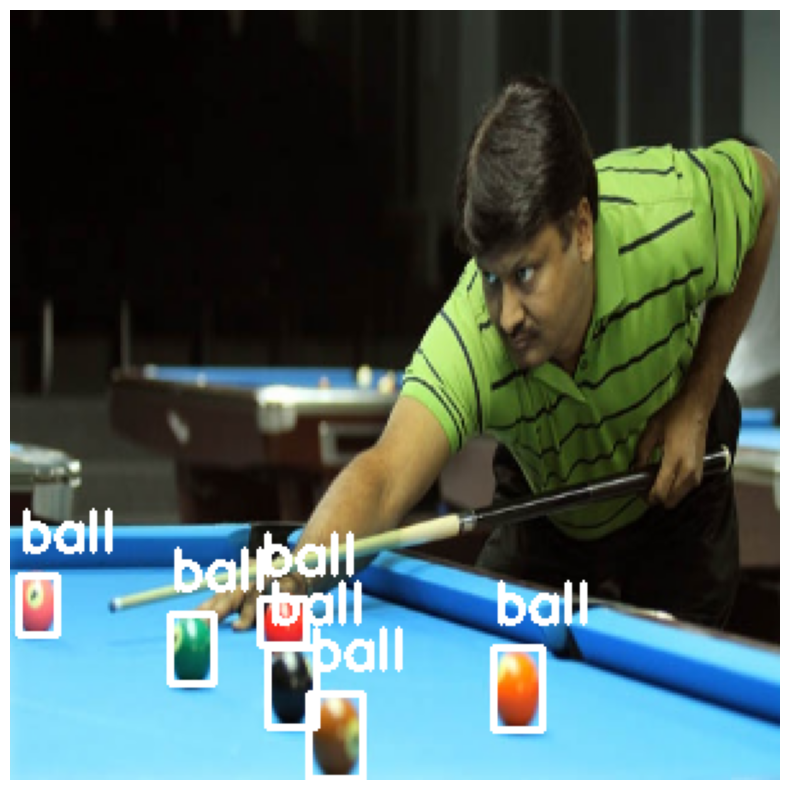

In [48]:
for sample in train_dataset:
    print(sample['img'].shape)
    img_with_bboxes = draw_predictions(sample['img'].permute(1,2,0), sample['boxes'], sample['labels'], scores = None, class_to_label_map = map_label_to_class )
    show_image(img_with_bboxes)
    break

Тестируем даталоадер

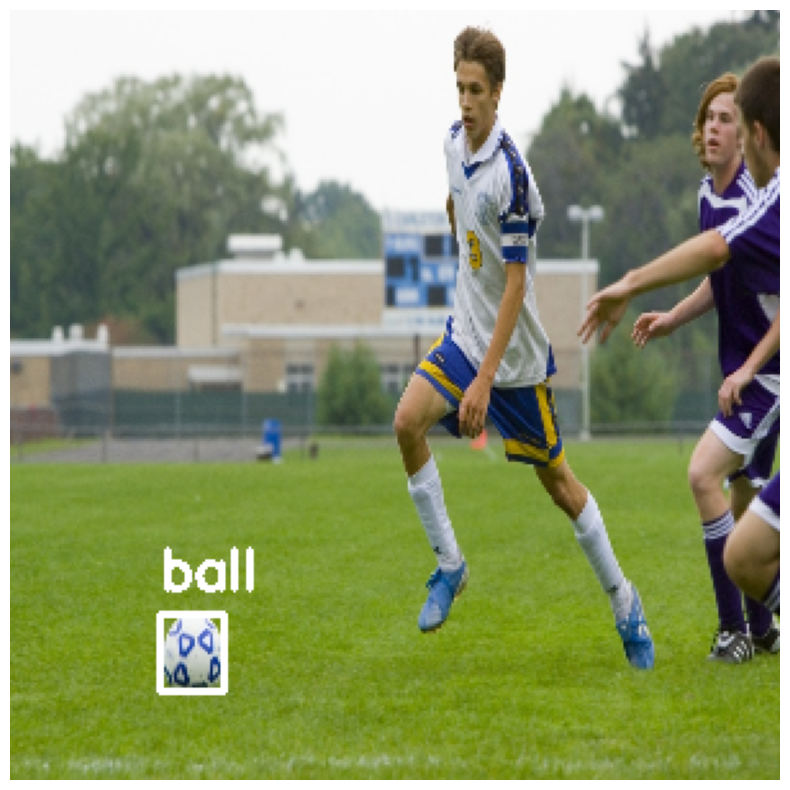

In [49]:

for sample in train_dataloader:
    img_with_bboxes = draw_predictions(sample['img'][0].permute(1,2,0), sample['boxes'][0], sample['labels'][0], scores = None, class_to_label_map = map_label_to_class )
    show_image(img_with_bboxes)
    break

### Обучение модели

Функция для обучения модели

In [50]:
def train(model, optimizer, epochs, train_loader, val_loader,scheduler =None):
    
    loss_train = []
    loss_regression_train = []
    loss_classification_train = []

    best_loss = -1
    best_weights = None
    for epoch in tqdm(range(epochs)):
        
        
        clear_output(wait=True)
        current_loss_train = []
        current_loss_regression_train = []
        current_loss_classification_train=[]
    

        model.train()
        for batch in train_loader:
            
            optimizer.zero_grad()
            images = [sample.to(device) for sample in batch['img']]
            annotations = [{"boxes": box.to(device), "labels": label.long().to(device)} 
                           for box, label in zip(batch['boxes'], batch['labels'])]

           
            #freeze BN if batch_size == 1
            if len(images)==1:
                for module in model.modules():
                    if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
                        module.eval()
            
            loss = model(images, annotations)
            
            full_loss = sum(loss for loss in loss.values())

            
            full_loss.backward()
            optimizer.step()
            
            current_loss_train.append(full_loss.item())
            current_loss_regression_train.append(loss['bbox_regression'].mean().item())
            current_loss_classification_train.append(loss['classification'].mean().item())
 
        if scheduler is not None:
            scheduler.step()
        
        loss_train.append(np.mean(current_loss_train))
        loss_regression_train.append(np.mean(current_loss_regression_train))
        loss_classification_train.append(np.mean(current_loss_classification_train))

        if best_loss < np.mean(current_loss_train):
            best_loss = np.mean(current_loss_train)
            best_weights = model.state_dict()
            
        print(f'On {epoch+1} epoch classification_loss: {loss_classification_train[epoch]}, regression_loss: {loss_regression_train[epoch]}, loss_train: {loss_train[epoch]}')

    # after training load best weigths
    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), 'best_weights.pt')
    return model,loss_train
    



Функция для тестирования модели. Метрика - mAP

In [51]:
!pip install mean_average_precision
from mean_average_precision import MetricBuilder

In [52]:

def evaluate(model, val_dataloader, threshold):
    model.eval()
    
    # Initialize the metric builder for mAP evaluation
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=2)
    
    for iter_num, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        for img, gt_boxes, gt_labels in zip(data['img'], data['boxes'], data['labels']):
            img = img.to(device)  
            
            with torch.no_grad():
                annotations = model(img.unsqueeze(0))[0]
            
            bboxes = annotations['boxes']
            nms_scores = annotations['scores']
            nms_classes = annotations['labels']

            preds = torch.cat([bboxes, nms_classes.unsqueeze(0).T, nms_scores.unsqueeze(0).T], dim=1).cpu().detach().numpy()
 
            zeros = torch.zeros((gt_boxes.shape[0], 1))
            gt = torch.cat([gt_boxes, gt_labels.unsqueeze(0).T, zeros, zeros], dim=1).cpu().detach().numpy()
 
            metric_fn.add(preds, gt)

            del img, gt, preds, zeros, nms_scores, nms_classes, bboxes
    
    mAP = metric_fn.value(iou_thresholds=threshold)['mAP']
    print("Mean Average Precision:", mAP)




В качестве модели я выберу ssd lite. Модель должна быстро обучаться

In [53]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights

In [297]:
gc.collect()
torch.cuda.empty_cache()

Возьмем предобученную модель с небольшим количеством аугментаций.

In [298]:
model_pretrained = ssdlite320_mobilenet_v3_large(weigths = SSDLite320_MobileNet_V3_Large_Weights, num_classes = 2)
model_pretrained.head.classification_head.num_classes = 2 #background + ball class
model_pretrained.to(device)
optimizer = torch.optim.AdamW(model_pretrained.parameters(),lr=3e-4)
scheduler = StepLR(optimizer,step_size = 10, gamma = 0.05)

model_pretrained, loss_train_pretrained = train(model_pretrained,optimizer, 30, train_dataloader, val_dataloader,scheduler=scheduler)

100%|██████████| 30/30 [28:34<00:00, 57.15s/it]

On 30 epoch classification_loss: 1.2669400854243174, regression_loss: 0.6470689991282093, loss_train: 1.9140090829796261


In [299]:
torch.save(model_pretrained.state_dict(), 'balls_detector_weigths_pretrained_model.pt')
model_pretrained.load_state_dict(torch.load('balls_detector_weigths_pretrained_model.pt',weights_only=True))

<All keys matched successfully>

In [300]:
evaluate(model_pretrained, val_dataloader, threshold=0.3)

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Mean Average Precision: 0.13690028


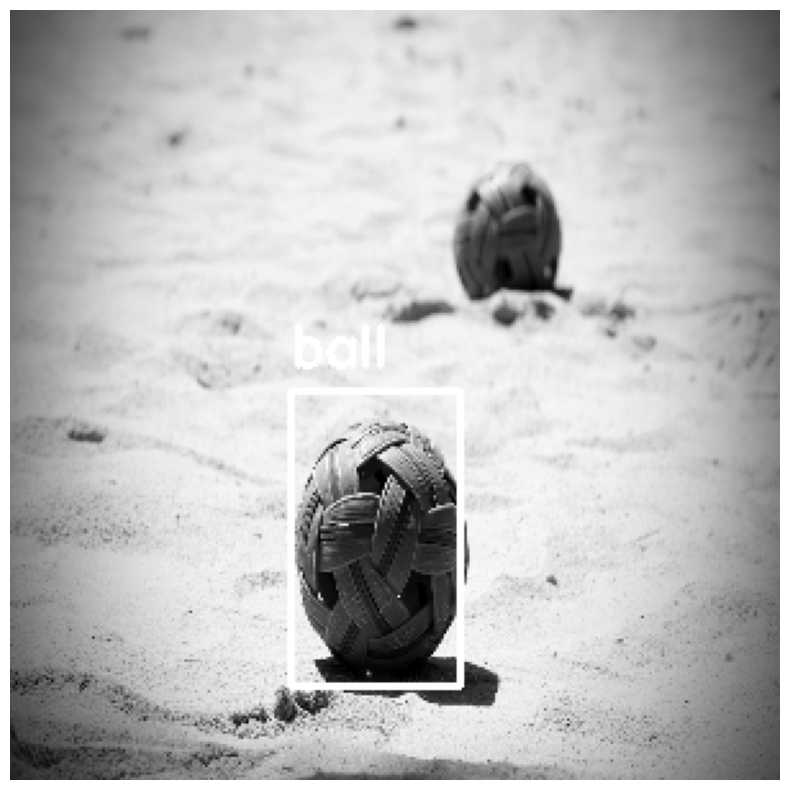

In [301]:
model_pretrained.eval()
with torch.no_grad():
    for sample in val_dataloader:
        predicted = model_pretrained([ s.to(device) for s in sample['img']])
        img_with_bboxes = draw_predictions(sample['img'][0].permute(1,2,0), predicted[0]['boxes'].cpu(), predicted[0]['labels'].cpu(), scores = predicted[0]['scores'].cpu(), class_to_label_map = map_label_to_class, threshold=0.3)
        show_image(img_with_bboxes)
        break

Модель показывает среднюю точность, распознает не все объекты

Теперь протестируем модель с другими параметрами: возьмем большее количество аугментаций, большее количество эпох, увеличим размер батча.

In [55]:
transformations_big_train = A.Compose([
    A.Resize(300,300),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter (brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.5, 0.5), always_apply=None, p=0.5),
    A.GaussianBlur(blur_limit=(3), p=0.5),
    A.GaussNoise (var_limit=(0.1), mean=0, per_channel=False, noise_scale_factor=1, always_apply=None, p=0.5),
    # A.Rotate( limit = (-15,15), p = 0.5 ),
    
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transformations = A.Compose([
    A.Resize(300,300),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_dataset_model_zero = DetectionDataset(data_dict_file="/kaggle/input/ball-detection-dataset/seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json", 
                                 transforms=transformations_big_train, add_path = '/kaggle/input/ball-detection-dataset/seminar_objdet_retina_oi5_ball/')

train_dataloader_model_zero = DataLoader(train_dataset_model_zero, batch_size = 32, shuffle = True, collate_fn=CustomCollater)



/opt/conda/lib/python3.10/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


Посмотрим, какое изображение может получиться

torch.Size([3, 274, 274])


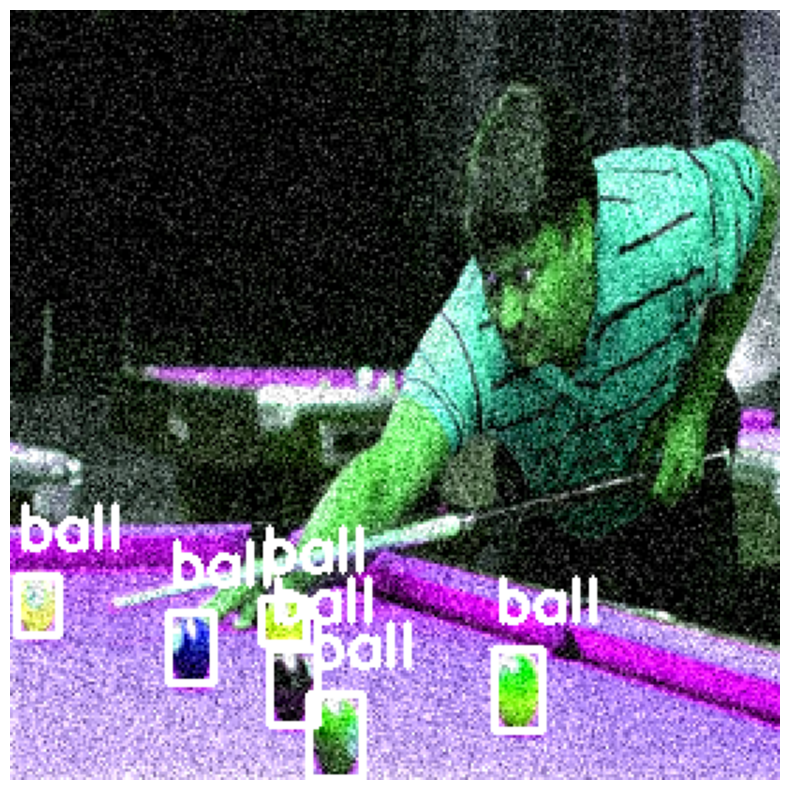

In [324]:
for sample in train_dataset_model_zero:
    print(sample['img'].shape)
    img_with_bboxes = draw_predictions(sample['img'].permute(1,2,0), sample['boxes'], sample['labels'], scores = None, class_to_label_map = map_label_to_class )
    show_image(img_with_bboxes)
    break

Стоит отметить, что модель будет без предобучения

In [325]:
model_from_zero = ssdlite320_mobilenet_v3_large(weigths = None, num_classes = 2)
model_from_zero.head.classification_head.num_classes = 2 #background + ball class
model_from_zero.to(device)

optimizer = torch.optim.AdamW(model_from_zero.parameters(),lr=3e-4)
scheduler = StepLR(optimizer,step_size = 10, gamma = 0.05)

model_from_zero, loss_train_from_zero = train(model_from_zero,optimizer, 100, train_dataloader_model_zero, val_dataloader, scheduler=scheduler)

100%|██████████| 100/100 [1:58:55<00:00, 71.36s/it]

On 100 epoch classification_loss: 1.6832605520884196, regression_loss: 0.9707026412089665, loss_train: 2.653963183032142


In [326]:
torch.save(model_from_zero.state_dict(), 'balls_detector_weigths_model_from_zero.pt')
model_from_zero.load_state_dict(torch.load('balls_detector_weigths_model_from_zero.pt',weights_only=True))

<All keys matched successfully>

In [327]:
evaluate(model_from_zero, val_dataloader, threshold=0.3)

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Mean Average Precision: 0.13875973


Точность немного выросла. Значит, добавление эпох и аугментаций помогло. Точность выросла не сильно, т.к. модель в этот раз была без предобученных весов

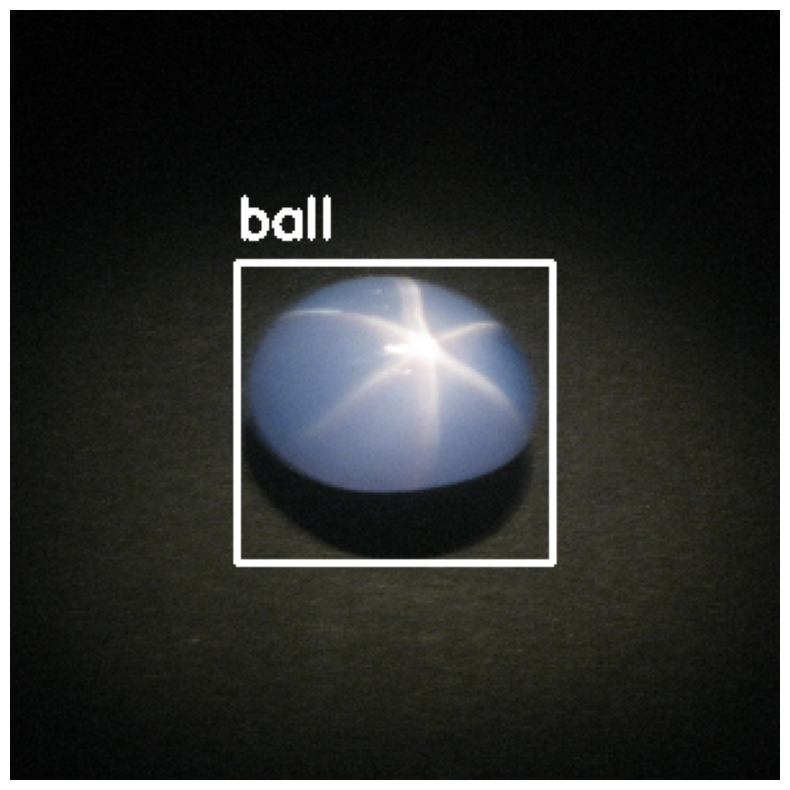

In [328]:
model_pretrained.eval()
with torch.no_grad():
    for sample in val_dataloader:
        predicted = model_from_zero([ s.to(device) for s in sample['img']])
        img_with_bboxes = draw_predictions(sample['img'][0].permute(1,2,0), predicted[0]['boxes'].cpu(), predicted[0]['labels'].cpu(), scores = predicted[0]['scores'].cpu(), class_to_label_map = map_label_to_class, threshold=0.3)
        show_image(img_with_bboxes)
        break

А сейчас объединим все. Теперь в основе будет предобученная модель. Обучим на 60 эпохах

In [56]:
model_final = ssdlite320_mobilenet_v3_large(weigths = SSDLite320_MobileNet_V3_Large_Weights, num_classes = 2)
model_final.head.classification_head.num_classes = 2 #background + ball class
model_final.to(device)
optimizer = torch.optim.AdamW(model_final.parameters(),lr=3e-4)
scheduler = StepLR(optimizer,step_size = 10, gamma = 0.05)

model_final, loss_train = train(model_final,optimizer, 60, train_dataloader_model_zero, val_dataloader,scheduler=scheduler)

100%|██████████| 60/60 [1:13:10<00:00, 73.18s/it]

On 60 epoch classification_loss: 1.6505741516749064, regression_loss: 0.9704841130309635, loss_train: 2.6210582666926916


In [68]:
torch.save(model_final.state_dict(), 'balls_detector_weigths_model_final.pt')
model_final.load_state_dict(torch.load('balls_detector_weigths_model_final.pt',weights_only=True))

<All keys matched successfully>

In [58]:
evaluate(model_final, val_dataloader, threshold=0.3)

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 15/15 [32:06<00:00, 128.42s/it]  


Mean Average Precision: 0.1443754


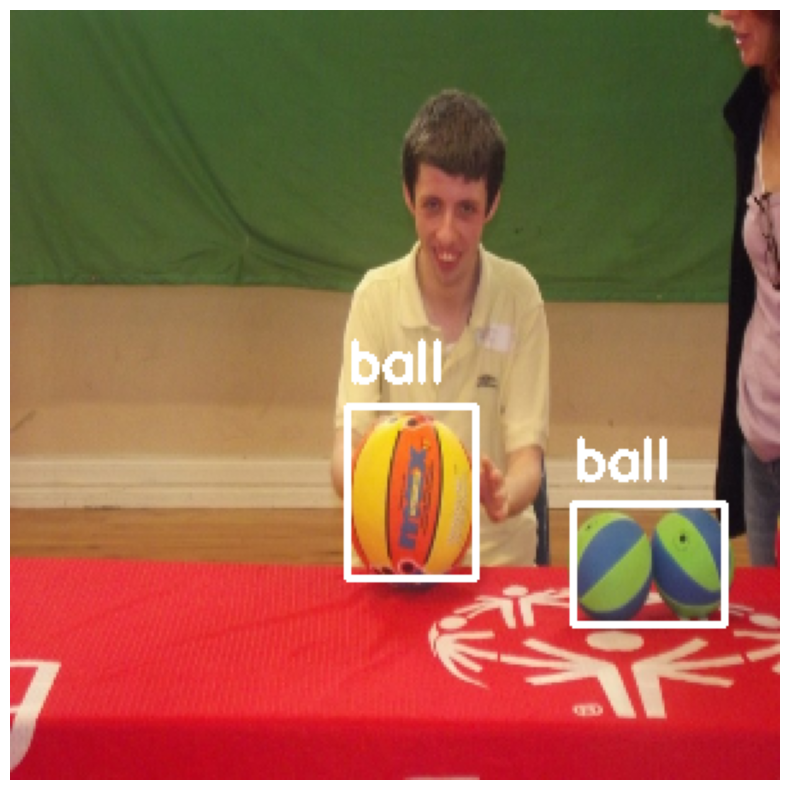

In [82]:
model_final.eval()
with torch.no_grad():
    for sample in val_dataloader:
        predicted = model_final([ s.to(device) for s in sample['img']])
        img_with_bboxes = draw_predictions(sample['img'][0].permute(1,2,0), predicted[0]['boxes'].cpu(), predicted[0]['labels'].cpu(), scores = predicted[0]['scores'].cpu(), class_to_label_map = map_label_to_class, threshold=0.3)
        show_image(img_with_bboxes)
        break

Видно, что точность модели выросла. Из этого следует вывод, что стоит добавлять больше аугментаций перед обучением модели, использовать больше эпох и брать предобученную модель